In [1]:
using DifferentialEquations, Plots, Test, BenchmarkTools, LinearAlgebra, SparseArrays, DiffEqOperators
using Perla1

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\Perla1\nyjg2.ji for Perla1 [c0b4307c-ed70-5091-a49a-e521e9681a02]
└ @ Base loading.jl:1184
┌ Warning: Package Perla1 does not have LinearAlgebra in its dependencies:
│ - If you have Perla1 checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Perla1
└ Loading LinearAlgebra into Perla1 from project dependency, future warnings for Perla1 are suppressed.


In [2]:
# N-firm cases
N = 6
T = 100.0
μ = 0.0
θ = 0.06 # baseline parameter from Perla16 (Appendix E.4)
θ_d = 0.0 # assume constant θ_d (for Krylov methods)
f0 = 0.5 # assume constant f0 (for Krylov methods)
# θ_d = 0.21 # baseline parameter from Perla16 (Appendix E.4)
f_0 = [1.0; fill(0.0, N)]

7-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

# Using transition matrix

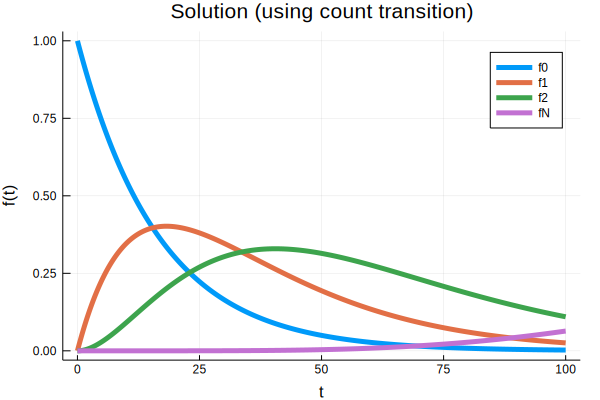

In [3]:
# get Q in matrix form for sanity check
function get_Q_matrix(N, μ, θ, θ_d, f0)
    dl = fill(μ, N)
    d = collect(-μ.-(N:-1:0).*(θ/N))
    du = collect((N:-1:1).*(θ/N))
    Q = LinearAlgebra.Tridiagonal(dl,d,du)

    Q[1,1] = -(θ + θ_d*(1-f0))
    Q[1,2] = θ + θ_d*(1-f0)

    return Q
end

# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_matrix, f_0, T)
    # solve transition dynamics given 
    # Q; N by N matrix generator
    # f_0; N vector of initial distribution
    # T; Float64 terminal time
    df(f,p,a) = Q_matrix' * f
    prob = DifferentialEquations.ODEProblem(df,f_0,(0.0,T))
    return solve(prob);
end

# define generator
Q = get_Q_matrix(N, μ, θ, θ_d, f0)

# solve the corresponding ODE
sol_count = solve_transition_dynamics_matrix(Q, f_0, T)

# convert to the counting solution
f0_count(a) = sol_count(a)[1]
f1_count(a) = sol_count(a)[2]
f2_count(a) = sol_count(a)[3]
fN_count(a) = sol_count(a)[end]

# plot
plot(0:0.01:T, [f0_count, f1_count, f2_count, fN_count], linewidth=5,
    title="Solution (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "fN"])

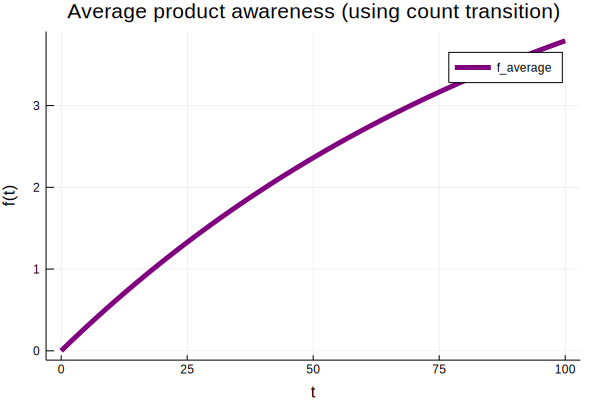

In [4]:
f_count(a) = dot(0:N, sol_count(a)) # average product awareness
plot(0:0.01:T, f_count,linewidth=5,
    title="Average product awareness (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple")

# Using Krylov method

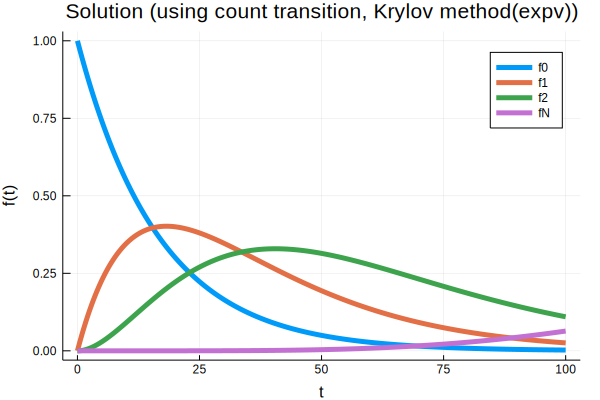

In [5]:

function mul!(y, Q::AwarenessModel, b)
    # note that the operator is transposed
    N = Q.N
    y[1] = -(Q.θ + Q.θ_d*(1-Q.f0))*b[1]+Q.dl[1]*b[2]
    for i in 2:N
        y[i] = Q.du[i-1]*b[i-1] + Q.d[i]*b[i] + Q.dl[i]*b[i+1]
    end
    y[2] = (Q.θ + Q.θ_d*(1-Q.f0))*b[1]+Q.d[2]*b[2]+Q.dl[2]*b[3]
    y[end] = Q.du[end]*b[N] + Q.d[end]*b[N+1]
end

function mul!(Y, Q::AwarenessModel, B::AbstractMatrix{T}) where {T}
    N = Q.N
    for j in 1:(N+1)
        y = Y[:,j]
        mul!(y, Q, B[:,j])
        Y[:,j] = y
    end
end

# some setups
using ExponentialUtilities

# generate an AwarenessModel
model = AwarenessModel(N, μ, θ, θ_d, f0)

# solve krylov
sol_count_krylov = solve_transition_dynamics(model, f_0)
f0_count_krylov(a) = sol_count_krylov(a)[1]
f1_count_krylov(a) = sol_count_krylov(a)[2]
f2_count_krylov(a) = sol_count_krylov(a)[3]
fN_count_krylov(a) = sol_count_krylov(a)[end]
f_count_krylov(a) = dot(0:N, sol_count(a)) # average product awareness

# plot
plot(0:0.1:T, [f0_count_krylov, f1_count_krylov, f2_count_krylov, fN_count_krylov], linewidth=5,
    title="Solution (using count transition, Krylov method(expv))",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "fN"])

In [6]:
# check if they yield identical results (in average awareness)
@test f_count.(0:0.1:T) ≈ f_count_krylov.(0:0.1:T) atol=1e-4

Test Passed